<a href="https://colab.research.google.com/github/vaf2112/dotfiles/blob/master/C%C3%B3pia_de_classify_electrocardiograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify Electrocardiograms

<img src='https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg' width=400>

### Exercise objectives:
- Discover a new type of application with temporal data
- Try different recurrent neural networks

We have seen that RNN are able to predict what happens after an observed sequence of data. Let's see here a different way of using RNN. Instead of predicting a value that occurs after the seen sequence, we will here classify the entire sequence itself, as if the whole sequence corresponds to a given category. 

## 1. Data

The data corresponds to electrocardiograms (ECG), which are basically heart beats. Each sequence is therefore a sequence of amplitudes. These ECG are often used to observe heart malfunctions! In this dataset, there are 87554 heart beats and each corresponds to a heart beat type, from 0 to 4:
- 0 : Normal beat
- 1 : Supraventricular
- 2 : Ventricular
- 3 : Fusion
- 4 : Beats that cannot be classified

### 1.2 Load Data
👇 Run the following command to download the data from [here](https://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip), unzip them, then read it as python object

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! wget "http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip"
! unzip ECG_data.zip
! rm ECG_data.zip

--2022-01-22 14:56:47--  http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30932601 (29M) [application/zip]
Saving to: ‘ECG_data.zip’

ECG_data.zip        100%[===================>]  29.50M  --.-KB/s    in 0.1s    

2022-01-22 14:56:47 (265 MB/s) - ‘ECG_data.zip’ saved [30932601/30932601]

Archive:  ECG_data.zip
   creating: ECG_data/
  inflating: ECG_data/X.npy          
  inflating: __MACOSX/ECG_data/._X.npy  
  inflating: ECG_data/y.npy          
  inflating: __MACOSX/ECG_data/._y.npy  


In [ ]:
import numpy as np

X = np.load(data_path + 'X.npy', allow_pickle=True).tolist()
y = np.load(data_path + 'y.npy', allow_pickle=True).tolist()

print(len(X), " time series") 

87554  time series


👇 We plot one ECG for each category in the dataset to see what an ECG looks like. Notice `np.argwhere` trick!

In [ ]:
len(X[2])

95

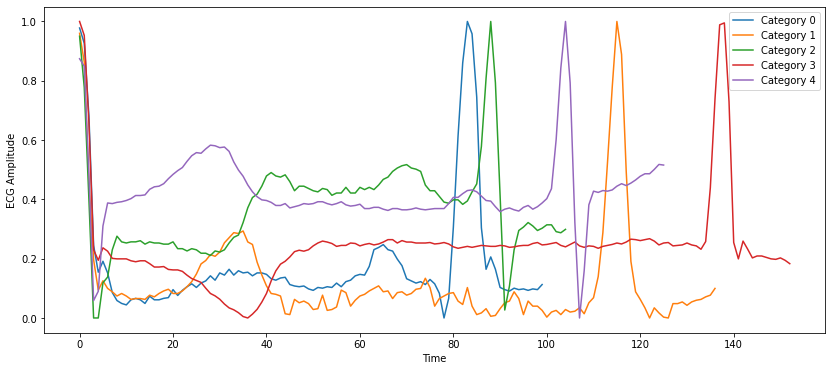

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i in range(5):
    idx_C = np.argwhere(np.array(y) == i)
    plt.plot(X[idx_C[0][0]], label=f'Category {i}')
    
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('ECG Amplitude')
plt.show()

### 1.2 Padding

❓ **Question** ❓ You have probably noticed that each sequence (each ECG) has a different length. To corroborate your observation, plot the distribution of the sequence lengths in the dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


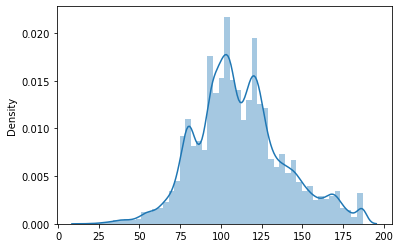

In [ ]:
# YOUR CODE HERE
import seaborn as sns

leng = []
for n in X:
  leng.append(len(n))

sns.distplot(leng)
plt.show()

You remember that we pass a batch of data to the neural network. Thus, the tensor will have the following shape 
>`(number of SEQUENCES, number of OBSERVATIONS per sequence, nbr of features per observation)`

- There are 87554 sequences
- Each observation is of size 1 (measured amplitude of ECG)

However, the number of observations per sequence vary from one sequence to another. For computational reasons, this cannot be feed into a RNN. For that reason, you need to **fill in the blanks** thanks to the [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) so that each sequence is filled with fake values. The resulting sequences will all be of the same length.

![image.png](attachment:image.png)



❓ **Question** ❓ Use the [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function on X directly (without extra arguments here), store the result in `X_pad` and print the first sequence.

In [ ]:
# YOUR CODE HERE

from tensorflow.keras.preprocessing.sequence import pad_sequences

X_pad = pad_sequences(X, dtype='float32', padding='post', value=-1000)
X_pad[0]

array([ 9.7794116e-01,  9.2647058e-01,  6.8137252e-01,  2.4509804e-01,
        1.5441176e-01,  1.9117647e-01,  1.5196079e-01,  8.5784316e-02,
        5.8823530e-02,  4.9019609e-02,  4.4117648e-02,  6.1274510e-02,
        6.6176474e-02,  6.1274510e-02,  4.9019609e-02,  7.3529415e-02,
        6.1274510e-02,  6.1274510e-02,  6.6176474e-02,  6.8627454e-02,
        9.5588237e-02,  7.5980395e-02,  9.3137257e-02,  1.0539216e-01,
        1.1519608e-01,  1.0294118e-01,  1.1764706e-01,  1.2500000e-01,
        1.4215687e-01,  1.2745099e-01,  1.5196079e-01,  1.4460784e-01,
        1.6421568e-01,  1.4460784e-01,  1.5931372e-01,  1.5196079e-01,
        1.5441176e-01,  1.4215687e-01,  1.5196079e-01,  1.5196079e-01,
        1.4705883e-01,  1.3235295e-01,  1.2745099e-01,  1.3480392e-01,
        1.3725491e-01,  1.1274510e-01,  1.0784314e-01,  1.0539216e-01,
        1.0784314e-01,  9.8039217e-02,  9.3137257e-02,  1.0294118e-01,
        1.0049020e-01,  1.0539216e-01,  1.0294118e-01,  1.1764706e-01,
      

❓ **Question** ❓ You probably see that the returned sequence is composed only of 0's. The reason is because, by default, `pad_sequences` returns integers. If a float is between 0.0 and 0.99999, it is converted to 0. To change this default behavior, turn the `dtype` argument of `pad_sequences` to `float32`. Pad once again the sequences, store the new result in `X_pad` and print the first sequence.

In [ ]:
# YOUR CODE HERE

The neural network, thanks to a `Masking` layer, will remove the 0 that you padded for computational reasons. 

**However**, if you look closely at the padded version of the first sequence, you have the padded zeros at the beginning of the sequence. But, also, there is a 0 value **_IN_** the heart-beat values. 
How could the neural network know which one to keep and which one to remove?

❓ **Question** ❓ Add the `value` keyword in the `pad_sequences` function to pad with values that **ARE NOT** in the initial dataset. Negative values for instance. Store it in `X_pad` and print the first sequence.

❗ **Remark** ❗ This is a good habit to pad the values **at the end** of the sequence (instead of the beginning as it is done by default). You can do that thanks to the `padding` keyword set to `post` (instead of `pre` by default).

[See full documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [ ]:
# YOUR CODE HERE

### 1.3 Reshaping

In [ ]:
type(X_pad)

numpy.ndarray

In [ ]:
X_pad.shape == (87554, 187)

True

☝️ We are missing one dimension, the last one (corresponding to the number of features per observations)

❓ **Question** ❓ To remedy this issue, expand the last dimension thanks to the `np.expand_dims` function. 

In [ ]:
# YOUR CODE HERE

X_pad = np.expand_dims(X_pad, axis = 2)

In [ ]:
X_pad.shape == (87554, 187, 1)

True

❓ **Question** ❓ The labels `y` have to be one-hot encoded categories. For that reason, transform them to categories thanks to the appropriate Keras function and store the result in `y_cat`

In [ ]:
# YOUR CODE HERE

from tensorflow.keras.utils import to_categorical

y = np.array(y)

In [ ]:
y_cat = to_categorical(y)

In [ ]:
y_cat.shape

(87554, 5)

❓ **Question** ❓ Split your data between a train and test set (80/20 ratio).

In [ ]:
# YOUR CODE HERE

train_size = 0.8
index = round(train_size * X_pad.shape[0])
X_train = X_pad[:index]
X_test = X_pad[index:]
y_train = y_cat[:index]
y_test = y_cat[index:]

# 2. Model

Compared with previous challenge, each sequences comprises of lots of observations (187 units of time), and your intuition should tell you that ALL of them matters to diagnosis diseases (not just the "recent" ones). 

The LSTM or GRU model, with their ability to avoid vanishing gradient, should be preferred over RNN.

❓ **Question** ❓ Write model that has the following layers:
- a Masking layer whose `mask_value` corresponds to the value you decided to pad your data with (it is probably a negative value as suggested) - this layer will simply tell the network not to take into account the computation artifact
- Two stacked `GRU` layers with 20 units each, and the `tanh` as the activation function
- a dense layer with 50 units
- a dropout layer with 20% drop
- a last layer

and print model `summary()`

In [ ]:
# YOUR CODE HERE

from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, GRU, Flatten
from tensorflow.keras.layers import Masking, Dropout

model = Sequential()
model.add(layers.Masking(mask_value = -1000, input_shape = (187, 1)))
model.add(GRU(units = 20, return_sequences = True, activation = 'tanh'))
model.add(GRU(units = 20, activation = 'tanh'))
model.add(layers.Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(5, activation = 'softmax'))

❓ **Question** ❓ Compile and train your model. 

You will notice that it can take a very long time per epoch, even with GPUs. RNNs are, by nature, harder to distribute than CNNs. Indeed, GPUs work best when `trainable_params` is large (which is not the case here), or when `batch_size` is large 

- To reduce the duration of each epoch, use a larger batch size (e.g 128)

- Use also very small patience equal to 1 should be sufficient. This is because you have a lot of sequences and thus, many optimizations per epochs, even with relatively large batch_size




In [ ]:
# YOUR CODE HERE

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=2, restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size=128,
          epochs=100,
          validation_split=0.2,
          callbacks=[es],
          verbose=1)

Epoch 1/100
438/438 [==============================] - 20s 28ms/step - loss: 0.7207 - accuracy: 0.8260 - val_loss: 0.6458 - val_accuracy: 0.8323
Epoch 2/100
438/438 [==============================] - 10s 23ms/step - loss: 0.6699 - accuracy: 0.8271 - val_loss: 0.6457 - val_accuracy: 0.8323
Epoch 3/100
438/438 [==============================] - 10s 23ms/step - loss: 0.6679 - accuracy: 0.8271 - val_loss: 0.6462 - val_accuracy: 0.8323
Epoch 4/100
438/438 [==============================] - 10s 23ms/step - loss: 0.6678 - accuracy: 0.8271 - val_loss: 0.6487 - val_accuracy: 0.8323


❓ **Question** ❓ Evaluate your model on the test data.

In [ ]:
# YOUR CODE HERE

model.evaluate(X_test, y_test)

548/548 [==============================] - 4s 8ms/step - loss: 0.6615 - accuracy: 0.8262


[0.661469578742981, 0.8262234926223755]

❓ **Question** ❓ What is the accuracy of a baseline model which would predict, for `y_test`, the most probable category in y_train.

In [ ]:
# YOUR CODE HERE
import pandas as pd

pd.Series(y).value_counts()

0    72471
4     6431
2     5788
1     2223
3      641
dtype: int64

In [ ]:
baseline = len(y_test[y_test[:, 0] == 1]) / len(y_test[:, 0])
baseline

0.8262235166466793

Basically, your RNNs are as good (bad?) as a model that predicts the most present category. The reason is probably because the RNNs really return only the most present category.

❓ **Question** ❓ Use the `predict` function to see what are the different categories the model is predicting. Compare the 5 predict probas of each sequence with the distribution of each 5 classes

In [ ]:
# YOUR CODE HERE

predictions = model.predict(X_test)

In [ ]:
for n in range(5):
  y_pred = round(predictions[:, n].mean(), 3)
  y_baseline = round(len(y_test[y_test[:, n] == 1]) / len(y_test[:, n]), 3)
  print(f'Category {n + 1}')
  print('Prediction:', y_pred)
  print('Baseline:', y_baseline)
  print('')

Category 1
Prediction: 0.835
Baseline: 0.826

Category 2
Prediction: 0.023
Baseline: 0.025

Category 3
Prediction: 0.06
Baseline: 0.067

Category 4
Prediction: 0.007
Baseline: 0.008

Category 5
Prediction: 0.076
Baseline: 0.074



😱 Your model is returning exactly the frequence of each labels in your training set!

👉 A possibility here is to either subsample the data to have balanced classes in the training set. Another possibility is to do some data augmentation on temporal data. However, none of these methods would work right away. In fact, predicting the category of ECG data is not an easy task - also, you have only **one** heart-beat per patient, no repetitions of them! 

Classifying ECG is actually quite a complex task! Don't try to improve results, you won't be able to do so from this too small a dataset.

**The lesson here is not to be satisfied with results until you have compare them to a baseline method.**

🏁 Congratulation!